We want to find mutations that we think could affect CTF. 
Our conditions - 

1. Mutations in the CDS
2. Mutations that are in the range of *200* nts from a domain (both 5' and 3') or in a domain
3. Mutations that are in a region of significantly conserved MFE. 
4. Mutations that cause a large change to the MFE. 
5. Mutations that occur in at least 0.5% of a specific cancer cohort/ pan-cancer and at least 2 individuals. 

## Imports

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
#from Utils_AllGenes import *
from tqdm import tqdm
import concurrent.futures
from Utils_MDR1 import calc_windows_mfe, calc_mfe_per_position, mutate_cds_sequence, reverse_complement, colors
from scipy.stats import hypergeom
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import concurrent.futures
import seaborn as sns
from typing import Union




## Functions

In [ ]:
def get_patient_count(cancer_type: str) -> int:
    patient_info_path = f"../Data/TCGA/{cancer_type}/PtntInfoTble.txt"
    df = pd.read_csv(patient_info_path)
    return df['patient_uuid'].nunique()


In [3]:
def calculate_frequencies(cur_gene_muts: pd.DataFrame, gene_name: str, cols_mut_id: list) -> pd.DataFrame:
    base_path = f"../Data/TCGA/AllGenes/{gene_name}/"
    all_maf_files = [f for f in os.listdir(base_path) if f.endswith('.maf')]


    tcga_cancer_types = [f.replace('.maf', '') for f in all_maf_files]
    cancer_type_frequencies = {}
    pan_cancer_counts = Counter()
    total_patients = 0
    mutation_total_counts = Counter()
    
    mutations_of_interest = set(cur_gene_muts['mut_id'])
    
    for maf_file in all_maf_files:
        cancer_type = maf_file.replace('.maf', '')
        if cancer_type in tcga_cancer_types:
            maf_path = os.path.join(base_path, maf_file)
            
            # Read only necessary columns from MAF file
            df = pd.read_csv(maf_path, sep='\t', comment='#', low_memory=False, usecols=cols_mut_id + ['case_id'])
            
            # Create mut_id column without using apply
            df['mut_id'] = df[cols_mut_id].astype(str).agg(':'.join, axis=1)
            
            # Filter for mutations of interest
            df = df[df['mut_id'].isin(mutations_of_interest)]
            
            # Count mutations 
            mut_counts = df.groupby('mut_id')['case_id'].nunique()
            
            # Get patient count for this cancer type
            patient_count = get_patient_count(cancer_type)
            total_patients += patient_count
            
            # Calculate frequency for this cancer type
            cancer_type_frequencies[cancer_type] = mut_counts / patient_count
            
            # Add to pan-cancer counts
            for mut_id, count in mut_counts.items():
                pan_cancer_counts[mut_id] += count
                mutation_total_counts[mut_id] += count
    
    # Calculate pan-cancer frequency
    pan_cancer_frequency = {mut: count / total_patients for mut, count in pan_cancer_counts.items()}
    
    # Add frequency columns to cur_gene_muts
    for cancer_type, frequencies in cancer_type_frequencies.items():
        cur_gene_muts[f'freq_{cancer_type}'] = cur_gene_muts['mut_id'].map(frequencies)
    
    cur_gene_muts['freq_pan_cancer'] = cur_gene_muts['mut_id'].map(pan_cancer_frequency)
    cur_gene_muts['total_count'] = cur_gene_muts['mut_id'].map(mutation_total_counts)
    
    # Filter mutations with frequency >= 1% in any cancer type or pan-cancer AND total count > 1
    freq_columns = [col for col in cur_gene_muts.columns if col.startswith('freq_')]
    high_freq_mask = (cur_gene_muts[freq_columns] >= 0.01).any(axis=1)
    multiple_occurrence_mask = cur_gene_muts['total_count'] > 1
    
    cur_gene_muts_filtered = cur_gene_muts[high_freq_mask & multiple_occurrence_mask]
    
    return cur_gene_muts_filtered

In [5]:
def filter_variants(variants_with_zscores, max_dist_from_domain, percentile_5, percentile_95, biomart, cols_mut_id):

    ''' filter according to criterions ''' 

    #proximity to domains
    a = abs(variants_with_zscores["Domain distance"]) <= max_dist_from_domain #domain distance is in amino-acids
    #extreme z-score
    b = (variants_with_zscores["MFE z-score"] <= percentile_5) | (variants_with_zscores["MFE z-score"] >= percentile_95)
    #remove mutations with unmet conditions
    extreme_df = variants_with_zscores[a & b].copy()

    # frequency (more than 2 patients and frequency in project is more than 1%)
    extreme_df_with_freq = pd.DataFrame()
    # first we need the gene name - this biomart table contains general info of all human protein coding genes
    extreme_df = pd.merge(extreme_df, biomart.drop_duplicates('Gene stable ID'), left_on='Gene', right_on = 'Gene stable ID', how='left')
    #calculate frequencies
    genes_cur_chromo = extreme_df["Gene name"].unique()
    for gene in genes_cur_chromo:
        cur_gene_muts = extreme_df[extreme_df["Gene name"] == gene].copy()
        cur_gene_muts_frequent = calculate_frequencies(cur_gene_muts, gene, cols_mut_id)  # keep only genes with >=1% in at least one cancer in TCGA or pan-cancer
        extreme_df_with_freq = pd.concat([extreme_df_with_freq, cur_gene_muts_frequent])
    return(extreme_df_with_freq)

In [9]:
def get_delta_mfe(gene: str, cds_position: int, mut_allele: str, strand: int) -> Union[float, int]:
    
    ''' 
    gene is the ENSG id. 
    Strand is either -1 (reverse) or 1 (forward), and is an int. 
    mut_allele is the mutation on the positive strand.
    cds_position is 1-based 
    '''
    
    # Get the CDS sequence
    genes_dict = pd.read_pickle(f"../Data/AllGenes/orthologs/cdna_dict/cdna_{gene}.pickle.gz")
    nt_CDS = genes_dict['data'][0]['homologies'][0]['source']['seq'][:-3] #removing stop codon -> msa was on aas and ttanslated back, so no info on stop codons

    #get mfe profile of the original sequence
    mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
    mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

    #get mfe profile of the mutated sequence
    if strand == -1:
        mut_allele = reverse_complement(mut_allele)
    nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, mut_allele) #mutate the sequence
    mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
    mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position
    
    delta_mfe = (mfe_positions_mut[0,cds_position - 1] - mfe_positions[0,cds_position - 1])

    return(delta_mfe, cds_position)


In [12]:
def apply_get_delta_mfe(row: pd.DataFrame, chr2cds: dict) -> pd.Series:
    '''
    Apply "get_delta_mfe" to a single row
    '''
    gene = row["Gene"]
    ensp = row["ENSP"]
    start_position = row["Start_Position"]
    tumor_allele = row["Tumor_Seq_Allele2"]
    strand = row["Strand"]
    
    # Calculate 1-based CDS position
    cds_position = chr2cds[(gene, ensp)][start_position - 1] + 1
    
    # Call get_delta_mfe function
    delta_mfe, cds_pos = get_delta_mfe(gene, cds_position, tumor_allele, strand)
    
    return pd.Series({'delta_mfe': delta_mfe, 'cds_position': cds_pos})


In [13]:
def get_extreme_ctf_variants_single_chromosome(chromo: int, percentile_5: float, percentile_95: float,
                                               max_dist_from_domain: int, biomart_df: pd.DataFrame, cols_mut_id: list,
                                               chr2cds: dict, delta_threshold: float) -> pd.DataFrame:
    ''' 
    This functions takes all variants of a single chromosome from TCGA and keeps all the ones that could impact CTF
    according to our defined conditions 
    '''

    ''' Load the variants of a single chromosome '''
    #get all cds variants of this chromosome, with all info neede including z-scores and domain distances
    variants_with_zscores = pd.read_pickle(f"../Data/TCGA/cds_mutations_chr{chromo}_with_zscores_domaindist.pickle")
    variants_with_zscores = variants_with_zscores[variants_with_zscores["Variant_Type"] == "SNP"].copy()
    invalid_zscores = [-1,1]
    variants_with_zscores = variants_with_zscores[~variants_with_zscores["MFE z-score"].isin(invalid_zscores)]

    ''' filter non-frequent variants, distant from domain variants, variants with non conserved z-scores '''
    extreme_df = filter_variants(variants_with_zscores, max_dist_from_domain, percentile_5, percentile_95, biomart_df, cols_mut_id)

    ''' Calculate mfe change and keep only variants that cause extreme changes''' 
    extreme_df[["delta_mfe", "cds_position"]] = extreme_df.apply(lambda row: apply_get_delta_mfe(row, chr2cds), axis=1)
    fast_variants = (extreme_df["MFE z-score"] < 0) & (extreme_df["delta_mfe"] >= delta_threshold)
    slow_variants = (extreme_df["MFE z-score"] > 0) & (extreme_df["delta_mfe"] <= -delta_threshold)
    extreme_df = extreme_df[fast_variants | slow_variants].copy()
    
    ''' Save '''
    output_path = f"../Results/TCGA/chr{chromo}.pickle"
    with open(output_path, 'wb') as handle:
        pickle.dump(extreme_df, handle)

    return(extreme_df)

In [14]:
def get_significant_positions(zscores_df: pd.DataFrame) -> pd.DataFrame:
    ''' 
    Get positions with significant z-scores for the CTF plot
    '''
    low_z = zscores_df["z-score"] < 0 #z-scores that are below the mean
    high_z = zscores_df["z-score"] > 0 #z-scores that are below the mean
    low_p = zscores_df["corrected p-value"] < 0.1 #z-scores with a p-value lower than 0.1 (could be high or low z-scores)
    good_pos = zscores_df["good_position"] == True #only z-scores at valid positions
    
    zscores_df["significantly_low_mfe"] = low_z & low_p & good_pos
    zscores_df["significantly_high_mfe"] = high_z & low_p & good_pos
    
    return(zscores_df)



In [16]:
def plot_v2_withcolumn(variant_name:str, cds_pos: int, mfe_scores_original: np.array, low_positions: np.array, high_positions: np.array, z_scores_vertical: pd.DataFrame, z_scores_column: pd.DataFrame) -> None:
    '''
    Plot the CTF model results 
    '''
    num_positions = mfe_scores_original.shape[0] #total number of positions in the CDS
    
    profile, = plt.plot(np.arange(num_positions), mfe_scores_original, c = "grey")

    #maxi = max(mfe_scores_original)
    #vertic = plt.axvline(x = cds_pos, color = colors[5])
    vertic = plt.axvline(x = cds_pos, color = "royalblue")

    # Replace dots with vertical lines
    ymin, ymax = plt.ylim()
    for xi in low_positions:
        plt.vlines(xi, ymin, ymax, colors=colors[3], label = None)  # Draw a vertical line at each data point's x-coordinate
    for xi in high_positions:
        plt.vlines(xi, ymin, ymax, colors=colors[6], label = None)  

    proxy1 = plt.Line2D([0], [0], linestyle='none', color=colors[3], marker='_', markersize = 10)
    proxy2 = plt.Line2D([0], [0], linestyle='none', color=colors[6], marker='_', markersize = 10)

    plt.legend([profile, vertic, proxy1, proxy2],["Mean across orthologs", "Position of variant", "Conserved low MFE","Conserved high MFE"], framealpha=0.5, prop={'size': 12}, loc = "lower left")

    plt.xlim([cds_pos - 100, cds_pos + 100])
    
    # pval_ver = np.round(z_scores_vertical.loc[cds_pos]["corrected p-value"],2)
    # pval_col = np.round(z_scores_column.loc[cds_pos]["corrected p-value"],2)

    plt.title(f"{variant_name}", size = 15)
#    plt.title(f"{variant_name}")

    plt.xlabel("CDS position [nt]", size = 15)
    plt.ylabel("MFE [kcal/mol]", size = 15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylim([ymin + 1, ymax - 1])
    
    plt.savefig(f'../Figures/co_trans/{variant_name}_RBFOX2.png', bbox_inches = "tight", dpi=500)

In [17]:
''' 

Plots and saves the MFE profiles of the original and mutated MDR1 CDS in the vicinity of a variant
"cds_pos_1base" - the positions of the mutations, relative to the CDS, 1-based. 
"mfe_positions" - the vector of mfe scores of the entire CDS. Each CDS position has one score. 
"mfe_positions_mutated" - same, but with the variant in "cds_pos_1base". 
"changed_from" - the original nucleotide in "cds_pos_1base"
"changed_to" - the nucleotide that is in "cds_pos_1base" after the variation. 
"pval" - in the notebook "p_vals_mfe.ipynb" we create randomomized sequences (the MDR1 CDS sequence with a single mutation), calculated the delta-mfe for the randomizations 
and obtained an empirical p-value. Here we retrieve it fore the plot. 

'''

def plot_mfe_change(cds_pos_1base: int, mfe_positions: np.array, mfe_positions_mutated: np.array, changed_from: str, changed_to: str, pval: float) -> None:
    
    plt.figure(figsize=(10, 6))

    x = np.arange(mfe_positions.shape[1]) + 1
    plt.plot(x, mfe_positions.T, label = f'{cds_pos_1base}:{changed_from}', c = 'slategrey')
    plt.plot(x, mfe_positions_mutated.T, label = f'{cds_pos_1base}:{changed_to}', c = 'red')
    delta = np.round((mfe_positions_mutated[0,cds_pos_1base - 1] - mfe_positions[0,cds_pos_1base - 1]),2)

    variant = f"{changed_from}{cds_pos_1base}{changed_to}"
    #plt.title(f"Effect of {variant} on the local MFE profile (delta = {delta}, p = {pval})")
    plt.title(f"{variant} (Delta = {delta}, p {pval})", size=25)

    plt.xlabel("CDS position [nt]", size=25)
    plt.ylabel("MFE [kcal/mol]", size=25)
    plt.axvline(x = cds_pos_1base, color = 'royalblue', label = 'position of variant')
    plt.scatter(cds_pos_1base, mfe_positions.T[cds_pos_1base - 1], c = "slategrey", s = 20 )
    plt.scatter(cds_pos_1base, mfe_positions_mutated.T[cds_pos_1base - 1], c = "red", s = 20)

    plt.text(cds_pos_1base + 1, mfe_positions_mutated.T[cds_pos_1base - 1] , np.round(mfe_positions_mutated[0,cds_pos_1base - 1],2), size=13)
    plt.text(cds_pos_1base - 9, mfe_positions.T[cds_pos_1base - 1], np.round(mfe_positions[0,cds_pos_1base - 1],2), size=13)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.legend(prop={'size': 20})
    x_min = cds_pos_1base - 50
    x_max = cds_pos_1base + 50

    plt.xlim([x_min,x_max])
    plt.savefig(f'../Figures/MFE/delta_mfe_{changed_from}{cds_pos_1base}{changed_to}_RBFOX2.png', bbox_inches = "tight", dpi=500)

    plt.show()


## Main

In [ ]:
''' define some needed parameters ''' 

# z-score percentiles (calculated using mfe scores of all CDS TCGA variants, across chromosomes)
percentile_5 = -6.1
percentile_95 = 4.2

#general info from biomart about human genes - needed in this case to obtain the gene name and strand  
biomart = pd.read_csv("../Data/Biomart/mart_export_v110.txt", sep = "\t") 
biomart = biomart[["Gene stable ID", "Gene name", "Strand"]].copy()

max_dist_from_domain = 67 #maximun distance from domain allowed

cols_mut_id = ["Gene", "Chromosome", "Start_Position", "Variant_Classification", "Reference_Allele", "Tumor_Seq_Allele2"]

chr2cds = pd.read_pickle("../Data/chr2cds.pickle")

chromosomes = [str(i) for i in range(1, 23)] + ['X', 'Y']

''' Run on parallel on all chromosomes - get the possibly CTF effecting variants from each chromosome ''' 

with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for chromo in chromosomes:
        futures.append(executor.submit(get_extreme_ctf_variants_single_chromosome, chromo = chromo, 
                                       percentile_5 = percentile_5, percentile_95 = percentile_95,
                                       max_dist_from_domain = max_dist_from_domain, biomart_df = biomart,
                                       cols_mut_id = cols_mut_id, chr2cds = chr2cds, delta_threshold = delta_threshold))
                                                                               

## Find interesting specific cases


In [2]:
''' Obtain the results from the different chromosomes and concatinate '''

extreme_df = pd.DataFrame()
    
chromosomes = [str(i) for i in range(1, 23)] + ['X', 'Y']

for chromo in chromosomes: 
    
    try:
        path_to_results = f"../Results/TCGA/chr{chromo}.pickle"
        extreme_df_cur_chromo = pd.read_pickle(path_to_results)
        extreme_df = pd.concat([extreme_df, extreme_df_cur_chromo], sort = False)
    except:
        pass
    



In [3]:
''' save the df for the supplemental file in the paper '''

extreme_df_save = extreme_df[["mut_id", "Gene name", "Chromosome", "Gene", "Domain distance", 
            "MFE z-score", "delta_mfe", "Variant_Classification", "Strand", 
            "Transcript_ID", "ENSP", 'freq_ACC', 'freq_BLCA', 'freq_BRCA', 'freq_CESC', 'freq_CHOL',
           'freq_COAD', 'freq_DLBC', 'freq_ESCA', 'freq_GBM', 'freq_HNSC',
           'freq_KICH', 'freq_KIRC', 'freq_KIRP', 'freq_LAML', 'freq_LGG',
           'freq_LIHC', 'freq_LUAD', 'freq_LUSC', 'freq_MESO', 'freq_OV',
           'freq_PAAD', 'freq_PCPG', 'freq_PRAD', 'freq_READ', 'freq_SARC',
           'freq_SKCM', 'freq_STAD', 'freq_TGCT', 'freq_THCA', 'freq_THYM',
           'freq_UCEC', 'freq_UCS', 'freq_UVM', 'freq_pan_cancer', 'total_count']].sort_values(by = "total_count", ascending = False)

extreme_df_save = extreme_df_save[extreme_df_save["Variant_Classification"]!= "Nonsense_Mutation"]
extreme_df_save.to_csv("../Results/extreme_df_tcga.tsv", sep='\t', index=False) #this is in Supplementary information file 3


In [7]:
extreme_df_save.sort_values("delta_mfe")

,mut_id,Gene name,Chromosome,Gene,Domain distance,MFE z-score,delta_mfe,Variant_Classification,Strand,Transcript_ID,...,freq_SKCM,freq_STAD,freq_TGCT,freq_THCA,freq_THYM,freq_UCEC,freq_UCS,freq_UVM,freq_pan_cancer,total_count
2476,ENSG00000101074:chr20:44345292:Silent:C:G,R3HDML,chr20,ENSG00000101074,0.0,5.131450,-3.733333,Silent,1.0,ENST00000217043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000898,10
4606,ENSG00000005022:chrX:119470437:Silent:T:G,SLC25A5,chrX,ENSG00000005022,0.0,5.880471,-3.628205,Silent,1.0,ENST00000317881,...,NaN,NaN,0.007463,0.005941,0.016129,0.032967,NaN,NaN,0.015079,168
2888,ENSG00000003987:chr8:17341444:Silent:T:C,MTMR7,chr8,ENSG00000003987,0.0,4.969523,-3.584615,Silent,-1.0,ENST00000180173,...,NaN,NaN,NaN,NaN,NaN,0.001832,NaN,NaN,0.001346,15
152,ENSG00000131473:chr17:41873838:Missense_Mutati...,ACLY,chr17,ENSG00000131473,-66.0,6.040604,-3.351282,Missense_Mutation,-1.0,ENST00000352035,...,NaN,0.013544,NaN,0.005941,NaN,NaN,NaN,NaN,0.011130,124
3545,ENSG00000090857:chr16:70130431:Missense_Mutati...,PDPR,chr16,ENSG00000090857,0.0,5.424185,-3.241026,Missense_Mutation,1.0,ENST00000288050,...,0.002128,0.002257,NaN,0.003960,NaN,0.001832,NaN,NaN,0.002334,26
4510,ENSG00000144749:chr3:66384219:Missense_Mutatio...,LRIG1,chr3,ENSG00000144749,17.0,7.754744,-3.076923,Missense_Mutation,-1.0,ENST00000273261,...,NaN,0.004515,0.007463,NaN,NaN,NaN,NaN,NaN,0.001885,21
2185,ENSG00000188677:chr22:44100073:Missense_Mutati...,PARVB,chr22,ENSG00000188677,0.0,5.268498,-2.897436,Missense_Mutation,1.0,ENST00000338758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000180,2
2228,ENSG00000100311:chr22:39230131:Missense_Mutati...,PDGFB,chr22,ENSG00000100311,0.0,4.234587,-2.846154,Missense_Mutation,-1.0,ENST00000331163,...,NaN,0.009029,NaN,0.005941,NaN,0.001832,NaN,NaN,0.006104,68
1039,ENSG00000047230:chrX:16639229:Silent:G:T,CTPS2,chrX,ENSG00000047230,0.0,4.871382,-2.828205,Silent,-1.0,ENST00000359276,...,0.023404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000987,11
1408,ENSG00000140848:chr16:57137159:Silent:T:G,CPNE2,chr16,ENSG00000140848,0.0,6.290708,-2.533333,Silent,1.0,ENST00000290776,...,NaN,NaN,NaN,0.003960,NaN,0.001832,NaN,NaN,0.002783,31


In [33]:
all_genes = os.listdir("../Data/AllGenes") # a list of all human genes with TCGA variants

all_cancer_genes = os.listdir("../Data/CancerousGenes") # a list of all cancer-related human genes with TCGA variants


In [16]:
with open('../Data/all_human_protein_coding_genes_list.txt', 'w') as file:
    for gene in all_genes:
        file.write(gene + '\n')


### Plot enrichment of cancerous genes in the extreme df - Figure 10e in the main paper

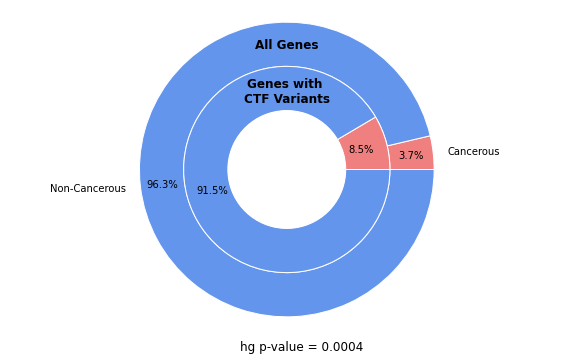

In [49]:
''' Check if there is enrichment of cancerous genes in the extreme df '''

all_genes = os.listdir("../Data/TCGA/AllGenes")
all_cancer_genes = os.listdir("../Data/TCGA/CancerousGenes")
genes_extreme_ctf_muts = list(extreme_df_save["Gene name"].unique())
cancerous_genes_extreme_ctf_muts = [gene for gene in genes_extreme_ctf_muts if gene in all_cancer_genes]

# is there an enrichment of cancer genes in the genes for which we found CTF-affecting mutations? hg test
total = len(np.unique(all_genes))
total_success = len(np.unique(all_cancer_genes))
sampled = len(np.unique(genes_extreme_ctf_muts))
sampled_success = len(np.unique(cancerous_genes_extreme_ctf_muts))

# Calculate the hypergeometric p-value
p_value = hypergeom.sf(sampled_success - 1, total, total_success, sampled)

# plot enrichment

total_genes = len(np.unique(all_genes))
cancerous_genes = len(np.unique(all_cancer_genes))

significant_genes =len(np.unique(genes_extreme_ctf_muts))
overlap_genes = len(np.unique(cancerous_genes_extreme_ctf_muts))

# Data
labels = ['Cancerous', 'Non-Cancerous']
sizes_total = [cancerous_genes, total_genes - cancerous_genes]
sizes_significant = [overlap_genes, significant_genes - overlap_genes]

fig, ax = plt.subplots(figsize=(10, 6))

# Total Genes Donut
ax.pie(sizes_total, labels = labels, autopct='%1.1f%%', startangle=0, pctdistance=0.85,
       colors=['lightcoral', 'cornflowerblue'], radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))

# Significant Genes Donut
ax.pie(sizes_significant, autopct='%1.1f%%', startangle=0, pctdistance=0.75,
       colors=['lightcoral', 'cornflowerblue'], radius=0.7, wedgeprops=dict(width=0.3, edgecolor='w'))

# Draw center circle to create the donut shape
centre_circle = plt.Circle((0,0),0.4,fc='white')
fig.gca().add_artist(centre_circle)

# Add text labels
ax.text(0, 0.85, 'All Genes', ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(0, 0.53, 'Genes with \nCTF Variants', ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(0.1, -1.2, 'hg p-value = 0.0004', ha='center', va='center', fontsize=12)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.savefig('../Figures/enrichment_in_CTF_set.png', dpi=300, bbox_inches='tight')

#plt.title('Proportion of Cancerous and Non-Cancerous Genes')
plt.show()


In [14]:
''' Finding specific interesting examples - Let's focus on synonymous variants'''

silent_extreme = extreme_df[extreme_df["Variant_Classification"] == "Silent"].sort_values(by = "freq_pan_cancer", ascending = False).copy()

## ENSG00000100320:chr22:35768281:Silent:G:T - RBFOX2

Things to check according to order (to not waste time): 

cds pos 732
uniprot:

0. Prevalence in dbSNP - rs573361634 - very uncommon in the healthy population
1. whether the variant is in the 3' of a domain or inside a domain. - 3' of the NBD 
1. proximity to introns (as it seems that most of the silent mutations affect through splicing...)  not very close . exon 6 [222-252]
2. results of spliceAI 
3. Conservation score - is somewhat conserved (1.14 score)
4. Details about the domain and the gene and whether this is interesting.



### Plot CTF model results for RBFOX2 variant - Figure 11f in the main paper

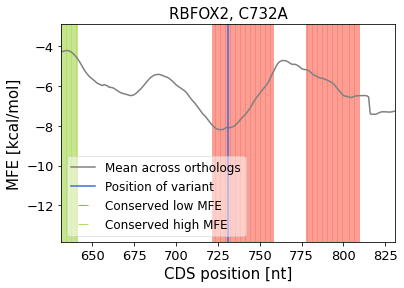

In [19]:
''' Check the z-scores conservation surrounding it '''

gene = "ENSG00000100320"
colors = sns.color_palette("Set3", 10)


''' Get the mfe profiles of the original MDR1 gene and the permutations '''
original = pd.read_pickle(f"../Results/AllGenes/mfe/mfe_scores/original/{gene}.pickle.gz")
column = pd.read_pickle(f"../Results/AllGenes/mfe/mfe_scores/column/{gene}.pickle.gz").mean(axis = 0)
vertical = pd.read_pickle(f"../Results/AllGenes/mfe/mfe_scores/vertical/{gene}.pickle.gz").mean(axis = 0)

''' Get the positions with the significantly low/high z-scores '''

#z-scores of all MDR1 cds positions
z_scores_vertical = pd.read_pickle(f"../Results/AllGenes/mfe/z-scores/{gene}_vertical.pickle")
z_scores_column = pd.read_pickle(f"../Results/AllGenes/mfe/z-scores/{gene}_column.pickle")

#add to each df two boolian columns indicating wether the position has significantly (p<0.1) low or high mfe
z_scores_vertical = get_significant_positions(z_scores_vertical)
z_scores_column = get_significant_positions(z_scores_column)

#get the positions for which there is concensus among vertical and column methods
low_mfe = (z_scores_vertical["significantly_low_mfe"] & z_scores_column["significantly_low_mfe"]).replace({True: 1, False: 0})
high_mfe = (z_scores_vertical["significantly_high_mfe"] & z_scores_column["significantly_high_mfe"]).replace({True: 1, False: 0})

low_positions = np.where(low_mfe == 1)[0] #the CDS positions with significantly low z-scores
high_positions = np.where(high_mfe == 1)[0]#the CDS positions with significantly high z-scores


variant_name = "RBFOX2, C732A"
cds_pos = 732 - 1 #0-based
plot_v2_withcolumn(variant_name, cds_pos, original, low_positions, high_positions, z_scores_vertical, z_scores_column)

# put the plot in the suplement files


### Plot MFE change for the RBFOX2 variant - Figure 11g in the main paper

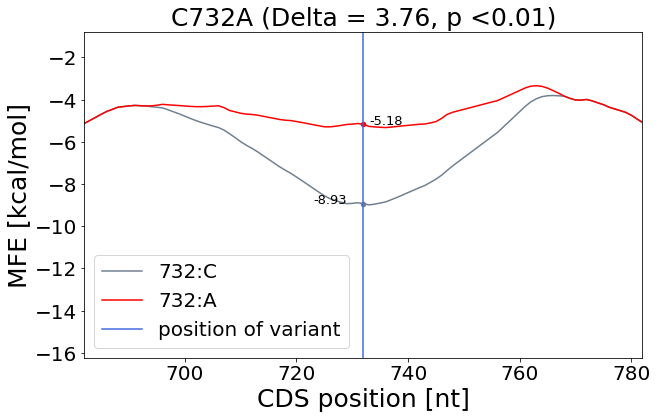

In [23]:
''' mfe '''

gene = "ENSG00000100320" #RBFOX2
genes_dict = pd.read_pickle(f"../Data/AllGenes/orthologs/cdna_dict/cdna_{gene}.pickle.gz")
nt_CDS= genes_dict['data'][0]['homologies'][0]['source']['seq'][:-3] #removing stop codon -> msa was on aas and ttanslated back, so no info on stop codons

cds_position = 732 #1-based
change_to = "A"
change_from = "C"

#get mfe profile of the original sequence
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

#get mfe profile of the mutated sequence
nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position

#we also calculated a p-value in the notebook "p_vals_mfe.ipynb"
pvalue = "<0.01" #calculated in "p_vals_mfe_SMC1A.ipynb" 

#plot both
plot_mfe_change(cds_position, mfe_positions, mfe_positions_mut, change_from, change_to, pvalue)


## Meta-data plot for TCGA extreme CTF mutations - Figure 10 in the main paper


In [ ]:
''' domain dist distribution (figure 10c)  '''


# Set the theme for seaborn
sns.set_theme(style="whitegrid")

# Create the histogram with enhancements
plt.figure(figsize=(10, 6))
sns.histplot(
    abs(extreme_df_save["Domain distance"]), 
    bins=10,  # Number of bins
    color="lightcoral",  # Set bar color
    edgecolor="black"  # Add black edges to the bars
)

# Customize labels and title
plt.xlabel("Distance from Domain [AA]", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Enhance the grid and plot layout
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.savefig(f'../Figures/folding_general/domain_distance_distribution_tcga.png', bbox_inches = "tight", dpi=500)

plt.show()


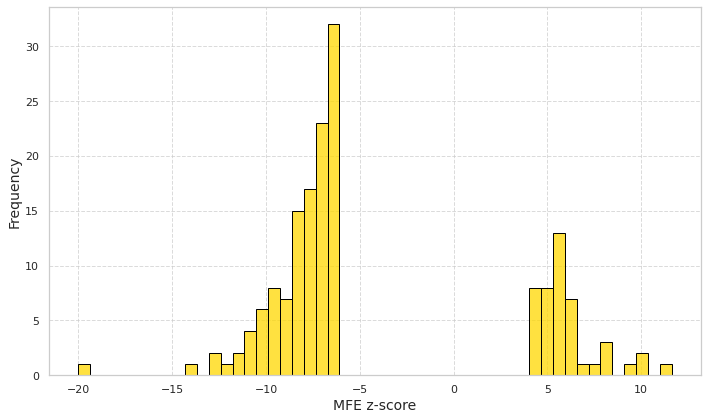

In [11]:
'''  MFE z-score distribution (Figure 10a) '''

# Set the theme for seaborn
sns.set_theme(style="whitegrid")

# Create the histogram with enhancements
plt.figure(figsize=(10, 6))
sns.histplot(
    extreme_df_save["MFE z-score"], 
    bins=50,  # Number of bins
    color="gold",  # Set bar color
    edgecolor="black"  # Add black edges to the bars
)

# Customize labels and title
plt.xlabel("MFE z-score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Enhance the grid and plot layout
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.savefig(f'../Figures/folding_general/zscore_distribution_tcga.png', bbox_inches = "tight", dpi=500)

plt.show()


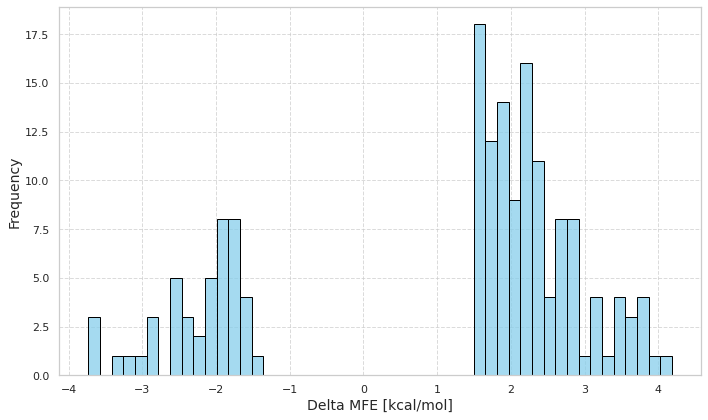

In [12]:
''' delta MFE distribution (Figure 10b)'''


# Set the theme for seaborn
sns.set_theme(style="whitegrid")

# Create the histogram with enhancements
plt.figure(figsize=(10, 6))
sns.histplot(
    extreme_df_save["delta_mfe"], 
    bins=50,  # Number of bins
    color="skyblue",  # Set bar color
    edgecolor="black"  # Add black edges to the bars
)

# Customize labels and title
plt.xlabel("Delta MFE [kcal/mol]", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Enhance the grid and plot layout
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.savefig(f'../Figures/folding_general/delta_mfe_distribution_tcga.png', bbox_inches = "tight", dpi=500)

plt.show()




In [113]:
''' Most frequent variants (Figure 10d)'''
freq_cols = [col for col in extreme_df_save.columns if "freq" in col]

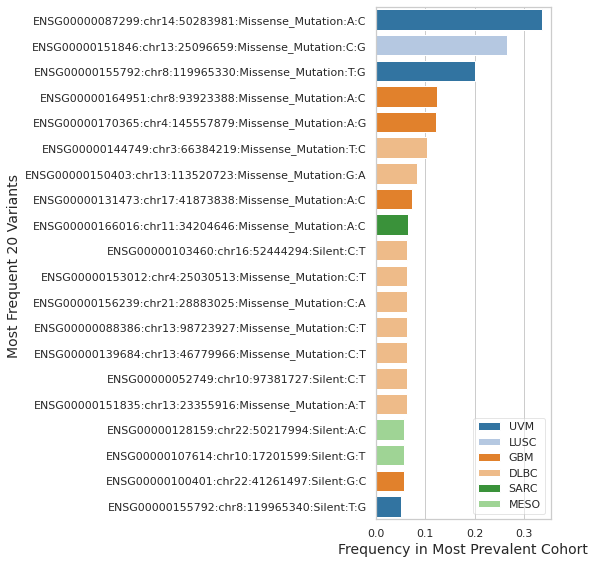

In [157]:
# create a column with the highest frequency
cancer_columns = [col for col in extreme_df_save.columns if "freq" in col]
max_freq = np.max(extreme_df_save[cancer_columns], 1)
extreme_df_save["max_freq"] = max_freq

#create a column with the cancer type with the highest frequency
cancer_columns = [col for col in extreme_df_save.columns if col.startswith('freq_') and col != 'freq_pan_cancer']
extreme_df_save['most_frequent_cancer'] = extreme_df_save[cancer_columns].idxmax(axis=1).str.replace('freq_', '')
extreme_df_save['most_frequent_cancer'] = extreme_df_save.apply(
    lambda row: 'pan_cancer' if row['freq_pan_cancer'] > row[cancer_columns].max() else row['most_frequent_cancer'],
    axis=1
)

#create the bar plot

extreme_df_save = extreme_df_save.sort_values(by = "max_freq", ascending = False)

sns.set_theme(style="whitegrid")
# Create the bar plot
plt.figure(figsize=(8, 8))
sns.barplot(
    y=extreme_df_save.iloc[:20]['mut_id'],
    x=extreme_df_save.iloc[:20]['max_freq'],  # The frequency in the most prevalent cancer
    hue=extreme_df_save.iloc[:20]['most_frequent_cancer'],  # Color by the most frequent cancer type
    dodge=False,  # Don't dodge bars to stack them directly on top of each other
    palette="tab20"  # Use a colormap with sufficient colors
)

# Customize labels and title
plt.ylabel("Most Frequent 20 Variants ", fontsize=14)
plt.xlabel("Frequency in Most Prevalent Cohort", fontsize=14)

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=90)

# Enhance the layout
plt.tight_layout()

plt.legend(framealpha = 0.5)

# Show the plot
plt.savefig(f'../MDR1/Figures/folding_general/top20_tcga_frequency.png', bbox_inches = "tight", dpi=500)

plt.show()


